In [1]:
import pandas as pd

from pycaret.classification import *

from features import analytical_tools
from utils import helper_funtions

In [2]:
pd.options.display.max_columns = None  # Remove "dots" from display when printing dataframes

In [3]:
PATH = helper_funtions.get_path()

# Read data

In [4]:
df = pd.read_csv(PATH + 'data/data_cleaning.csv')

,UUID_client,Age,Location,Income,TAX,Previous_sales,Type_products,Contact_channel,Contact_hour,Num_contacts,Satisfaction_score,Sales
38,dea2dfca-1957-5934-8fcf-5d473cee64eb,28,CA,57490.0,8623.50,0,C,Phone,11:30:00,3,4,0
7,c06243dc-eaed-5ddf-bc34-c28ae6c89ede,58,FL,67412.0,10111.80,4,A,Online Chat,08:30:00,2,4,1
284,d8883046-5550-57c5-9d49-c4075b326a09,34,TX,44484.0,6672.60,1,A,Email,14:30:00,1,4,0
873,67a326e4-83e5-5c62-aa7c-4d666dad74a0,63,IL,62994.0,9449.10,0,A,Email,08:15:00,2,3,0
988,fbe68436-2e74-579c-9fac-e9283426626f,58,FL,89659.0,13448.85,0,B,Email,14:00:00,4,1,0


# Preprocesing

In [5]:
# Determine peak times by rounding the time in groups of one hour 
df['Contact_hour'] = pd.to_datetime(df['Contact_hour'], format='%H:%M:%S')
df['Contact_hour_round'] = df['Contact_hour'].apply(lambda x: x.round('60 min'))

df_peak_time = df['Contact_hour_round'].value_counts().head()
df_peak_time = df_peak_time.rename_axis('Hour')
df_peak_time = df_peak_time.reset_index(name='Count')
peak_hours = []
for i in range(len(df_peak_time)):
    peak_hours.append(df_peak_time['Hour'].iloc[i])

for i in range(len(df)):
    if df.loc[i, 'Contact_hour_round'] in peak_hours:
        df.at[i, 'Is_peak_hour'] = 1
    else:
        df.at[i, 'Is_peak_hour'] = 0

del df_peak_time

In [7]:
# Obtener el porcentaje de impuesto
df['TAX_percent'] = (df['TAX'].mul(100) / df['Income']).round(0)
df['TAX_percent'].value_counts()

15.0    996
Name: TAX_percent, dtype: int64

# Simple imputation

In [8]:
df_new = df.query("Age < 70")
mean_age = df_new['Age'].mean()

index = df.query("Age > 70").index[0]

df.at[index, 'Age'] = mean_age

In [9]:
df_new = df.query("Previous_sales > 0")
mean_previous_sales = df_new['Previous_sales'].mean()

indexes = []
for i in range(0, len(df.query("Previous_sales < 0").index)):
    indexes.append(df.query("Previous_sales < 0").index[i])

for index in indexes:
    df.at[index, 'Previous_sales'] = mean_previous_sales

In [10]:
len(df.query("Num_contacts > 5"))

181

# Label encoders

In [11]:
labels_to_encoders_name = {
    'Contact_channel':'Contact_channel_ENC',
    'Type_products':'Type_products_ENC',
    'Contact_hour_round':'Contact_hour_round_ENC'}

for var_encoder, encoder_name in labels_to_encoders_name.items():
    analytical_tools.label_encoder(var_encoder, encoder_name, df)

In [12]:
df[['Contact_channel','Contact_channel_ENC',
    'Type_products','Type_products_ENC',
    'Contact_hour_round','Contact_hour_round_ENC']].head(5)

,Contact_channel,Contact_channel_ENC,Type_products,Type_products_ENC,Contact_hour_round,Contact_hour_round_ENC
0,Email,0,B,1,1900-01-01 06:00:00,2
1,Phone,2,A,0,1900-01-01 17:00:00,13
2,Online Chat,1,C,2,1900-01-01 06:00:00,2
3,Email,0,A,0,1900-01-01 06:00:00,2
4,Email,0,B,1,1900-01-01 09:00:00,5


# Model

In [ ]:
df_new = df[[
    'Income', 'Previous_sales', 'Num_contacts', 'Satisfaction_score', 
    'Sales', 'Is_peak_hour', 'Contact_channel_ENC',
    'Type_products_ENC', 'Contact_hour_round_ENC'
    ]].copy()

In [15]:
data = df_new.sample(frac=0.8, random_state=0)
data_unseen = df.drop(data.index)

In [16]:
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print(f'Datos para modelar: {data.shape}; y datos para predecir: {data_unseen.shape}')

Datos para modelar: (800, 9); y datos para predecir: (200, 18)


In [17]:
model_setup = setup(data=data, target='Sales')

,Description,Value
0,Session id,8505
1,Target,Sales
2,Target type,Binary
3,Original data shape,"(800, 9)"
4,Transformed data shape,"(800, 9)"
5,Transformed train set shape,"(560, 9)"
6,Transformed test set shape,"(240, 9)"
7,Numeric features,8
8,Rows with missing values,0.5%
9,Preprocess,True


In [18]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [19]:
best_models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8893,0.9473,0.8025,0.8053,0.7989,0.7229,0.7271,0.0200
rf,Random Forest Classifier,0.8875,0.9523,0.7567,0.8368,0.7840,0.7090,0.7184,0.0380
lightgbm,Light Gradient Boosting Machine,0.8875,0.9471,0.7775,0.8156,0.7911,0.7145,0.7188,0.0480
xgboost,Extreme Gradient Boosting,0.8839,0.9443,0.7638,0.8159,0.7813,0.7029,0.7095,0.0910
catboost,CatBoost Classifier,0.8821,0.9519,0.7771,0.8135,0.7834,0.7034,0.7127,0.3950
ada,Ada Boost Classifier,0.8732,0.9352,0.7825,0.7733,0.7714,0.6843,0.6894,0.0210
et,Extra Trees Classifier,0.8643,0.9130,0.6525,0.8329,0.7218,0.6347,0.6493,0.0330
dt,Decision Tree Classifier,0.8482,0.8004,0.6967,0.7422,0.7139,0.6110,0.6153,0.0050
qda,Quadratic Discriminant Analysis,0.8179,0.8568,0.5733,0.7171,0.6303,0.5123,0.5223,0.0060
nb,Naive Bayes,0.8089,0.8507,0.5458,0.7074,0.6050,0.4832,0.4965,0.0060


In [20]:
rf = create_model('rf')
print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9464,0.9797,0.9333,0.8750,0.9032,0.8662,0.8671
1,0.9107,0.9650,0.6667,1.0000,0.8000,0.7455,0.7708
2,0.8393,0.9220,0.8000,0.6667,0.7273,0.6147,0.6198
3,0.8214,0.9211,0.6667,0.6667,0.6667,0.5447,0.5447
4,0.9286,0.9837,0.8000,0.9231,0.8571,0.8098,0.8135
5,0.8750,0.9634,0.8667,0.7222,0.7879,0.7003,0.7062
6,0.8750,0.9341,0.5333,1.0000,0.6957,0.6260,0.6749
7,0.9107,0.9691,0.8000,0.8571,0.8276,0.7674,0.7683
8,0.8929,0.9445,0.7500,0.8571,0.8000,0.7273,0.7303


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=8505, verbose=0, warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9643,0.9902,0.9333,0.9333,0.9333,0.9089,0.9089
1,0.9286,0.9756,0.8000,0.9231,0.8571,0.8098,0.8135
2,0.8571,0.9350,0.8667,0.6842,0.7647,0.6642,0.6737
3,0.8571,0.9138,0.8667,0.6842,0.7647,0.6642,0.6737
4,0.9464,0.9902,0.9333,0.8750,0.9032,0.8662,0.8671
5,0.8571,0.9496,0.8667,0.6842,0.7647,0.6642,0.6737
6,0.8750,0.9366,0.7333,0.7857,0.7586,0.6744,0.6751
7,0.9286,0.9740,0.9333,0.8235,0.8750,0.8253,0.8284
8,0.9107,0.9547,0.8750,0.8235,0.8485,0.7853,0.7860


Fitting 10 folds for each of 10 candidates, totalling 100 fits


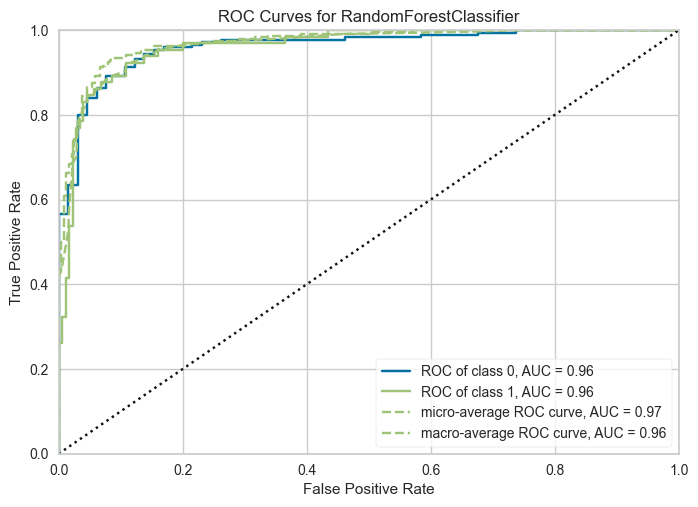

In [21]:
tuned_rf = tune_model(rf)
plot_model(tuned_rf, plot='auc')

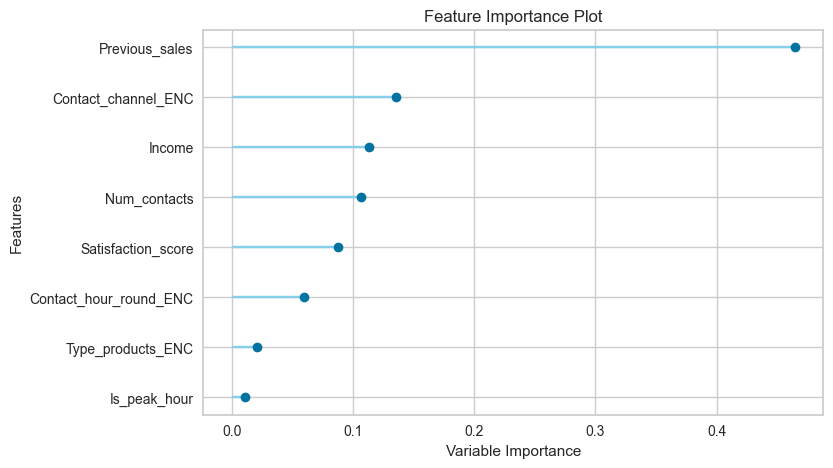

In [22]:
plot_model(tuned_rf, plot='feature')

In [24]:
unseen_predictions = predict_model(tuned_rf, data=data_unseen)
unseen_predictions[['Sales', 'prediction_label', 'prediction_score']].sample(n=25).head(25)

,Sales,prediction_label,prediction_score
140,0,0,0.9555
55,0,0,0.6321
33,0,0,0.9899
74,0,0,0.9930
173,0,0,0.9966
87,0,0,0.6341
130,1,1,0.7371
105,0,0,0.9767
67,0,0,0.9947
131,0,0,0.5245


In [26]:
final_rf = finalize_model(tuned_rf)
print(final_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9170,0.9777,0.9145,0.8039,0.8557,0.7977,0.8010


,Sales,prediction_label,prediction_score
385,0,0,0.9864
723,0,0,0.9700
575,0,0,0.9853
145,1,1,0.9462
753,0,1,0.6800
669,0,0,0.8836
972,0,0,0.9827
636,0,0,0.9400
579,1,0,0.5832
421,0,0,0.9942


# Save

In [28]:
save_model(final_rf, PATH + 'models/RF_model_28-01-2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Income', 'Previous_sales',
                                              'Num_contacts',
                                              'Satisfaction_score',
                                              'Is_peak_hour',
                                              'Contact_channel_ENC',
                                              'Type_products_ENC',
                                              'Contact_hour_round_ENC'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                  RandomForestClassifier(bootstrap=True, ccp_alp